# Mini-project
New York University Tandon School Of Engineering \\
Jesse Inouye, Shashvat Shah, Flavjo Xhelollari \\
`{jai9962,sss9772,fx2078} @nyu.edu`

In this project we modify the ResNet architecture, in order to
achieve high accuracy on CIFAR-10 dataset for image classi-
fication. The model has ~4.3M parameters and reaches a test
accuracy of ~96%.

In [ ]:
# Import the necessary library to mount Google Drive
from google.colab import drive

# Mount your Google Drive to access files
# This will prompt you to visit a link to get an authorization code
# After entering the code, your Google Drive will be mounted to Colab
drive.mount('/content/drive')

In [ ]:
# Import necessary PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import PyTorch vision modules for data loading and preprocessing
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

# Import summary from torchsummary for model summary
from torchsummary import summary

# Import numpy and os for additional functionality
import numpy as np
import os
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
# Initialize empty lists to store train and test accuracies and losses
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []
learning_rate_hist = []

# Set the device to GPU if available, otherwise use CPU
device = 'gpu'
if (device == 'gpu' and torch.cuda.is_available() == True):
    print("Using cuda")
    device = 'cuda'
else:
    print("Using cpu")
    device = 'cpu'

# Set the root and data paths to the appropriate directories
root_path = "drive/MyDrive/"
data_path = os.path.join(root_path, 'resnet_data')

# Uncomment if running locally
# data_path = '.data'

Using cuda


In [ ]:
# Define hyperparameters for the ResNet18 model architecture,
# Define hyperparameters for the SGD optimizer,
# Define batch sizes for training and testing.

# conv before residual blocks
conv0_kernel_size = 3
conv0_output_dim = 64
conv0_stride = 1
conv0_padding = 1

# Residual block convs
conv1_kernel_size = 5
conv1_padding = 2
conv2_kernel_size = 3
conv2_padding = 1

# Risidual layers
layer1_stride = 1
layer2_stride = 1
layer3_stride = 2
layer4_stride = 2
layer5_stride = 2

layer1_output_dim = 64
layer2_output_dim = 64
layer3_output_dim = 128
layer4_output_dim = 256
layer5_output_dim = 256

# Skip connection conv kernel size
skip_conn_conv_kernel_size = 1

# Avg pool at the end
avg_pool_kernel_size = 4

# SGD
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4

# Batch sizes
train_batch_size = 128
test_batch_size = 128



## ResNet Architecture
The ResNet18 model consists of several residual blocks, each of which contains two convolutional layers and a shortcut connection that allows gradients to flow more easily during training. The model starts with a single convolutional layer followed by four groups of residual blocks, with the number of blocks per group determined by the num_blocks parameter in the Resnet class. The output of the last residual block is passed through an average pooling layer and then a linear layer that produces the final classification scores.

In [ ]:
"""
  Implementing classes for the blocks in ResNet,
  and ResNet itself.
"""
class ResnetBlock(nn.Module):

    # Expansion factor for the residual connection
    expansion = 1

    def __init__(self, input_dim, output_dim, stride=1):

        super(ResnetBlock, self).__init__()

        # Convolutional layers for the residual block

        self.conv1 = nn.Conv2d(
            input_dim, output_dim, kernel_size=conv1_kernel_size, stride=stride, padding=conv1_padding, bias=False)

        self.bn1 = nn.BatchNorm2d(output_dim)

        self.conv2 = nn.Conv2d(output_dim, output_dim,
                               kernel_size=conv2_kernel_size, stride=1, padding=conv2_padding, bias=False)

        self.bn2 = nn.BatchNorm2d(output_dim)

        # Residual connection layers
        self.residual = nn.Sequential()

        # If the input and output dimensions are not the same, apply a 1x1 convolutional layer and batch normalization to match the output dimension
        if stride != 1 or input_dim != self.expansion*output_dim:
            self.residual = nn.Sequential(nn.Conv2d(input_dim, self.expansion*output_dim, kernel_size=skip_conn_conv_kernel_size,
                                          stride=stride, bias=False), nn.BatchNorm2d(self.expansion*output_dim))

    # Forward pass
    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output += self.residual(x)
        # Add the residual connection
        output = F.relu(output)
        return output


class Resnet(nn.Module):
    def __init__(self, moduleBlock: ResnetBlock, num_blocks, out_classes=10):
        super(Resnet, self).__init__()
        # First convolutional layer before the residual blocks        
        self.out_channels = conv0_output_dim
        self.conv1 = nn.Conv2d(3, conv0_output_dim, kernel_size=conv0_kernel_size, stride=conv0_stride, padding=conv0_padding, bias=False)
        self.bn1 = nn.BatchNorm2d(self.out_channels)

        # Residual blocks
        self.layer1 = self._create_layer(
            moduleBlock, layer1_output_dim, num_blocks[0], stride=layer1_stride)
        self.layer2 = self._create_layer(
            moduleBlock, layer2_output_dim, num_blocks[1], stride=layer2_stride)
        self.layer3 = self._create_layer(
            moduleBlock, layer3_output_dim, num_blocks[2], stride=layer3_stride)
        self.layer4 = self._create_layer(
            moduleBlock, layer4_output_dim, num_blocks[3], stride=layer4_stride)
        self.layer5 = self._create_layer(
            moduleBlock, layer5_output_dim, num_blocks[3], stride=layer5_stride)
        
        # Fully connected layer for classification
        self.linear = nn.Linear(layer4_output_dim*moduleBlock.expansion, out_classes)

    def _create_layer(self, moduleBlock: ResnetBlock, channels, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        # Create each residual block in the layer with the specified number of blocks and stride
        for s in strides:
            layers.append(moduleBlock(self.out_channels, channels, s))
            self.out_channels = channels*moduleBlock.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        # Pass through the residual blocks
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)

        output = F.avg_pool2d(output, avg_pool_kernel_size)
        output = output.view(output.size(0), -1)
        output = self.linear(output)
        return output


def ResNet18():
    return Resnet(ResnetBlock, [2 , 2 , 1, 1])


In [ ]:
model = ResNet18().to(device)
print(summary(model,(3,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,728
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]         102,400
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
       ResnetBlock-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]         102,400
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]          36,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
      ResnetBlock-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]         102,400
      BatchNorm2d-14           [-1, 64,

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # Initialize the early stopping object with a patience value and a minimum delta value.
        # The patience value is the number of epochs to wait for improvement in validation loss.
        # The min_delta value is the minimum change in validation loss to consider as an improvement.
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        # Check if the validation loss has improved since the last epoch.
        if validation_loss < self.min_validation_loss:
            # If the validation loss has improved, reset the counter and update the minimum validation loss.
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # If the validation loss has not improved, increment the counter and check if it has exceeded patience.
            # If the counter has exceeded patience, return True to indicate that early stopping should be applied.
            self.counter += 1
            if self.counter >= self.patience:
                return True
        # If early stopping is not triggered, return False.
        return False

In [ ]:
def training(trainData, model, loss_fn, optim_fn, epoch, optimizer_scheduler=None):
    # Per epoch
    print(f'training epoch: {epoch} started')
    curr_loss = 0.0
    correct_pred = 0
    total_labels = 0

    # train mode
    model.train()

    # split dataset into 80% train and 20% test
    trainDataSet, validationDataSet = random_split(trainData, [0.8, 0.2])
    
    trainDataLoader = DataLoader(trainDataSet, batch_size=train_batch_size, shuffle=True, num_workers=2)
    validationDataLoader = DataLoader(validationDataSet, batch_size=test_batch_size, num_workers=2)
    
    # loop through the train data loader
    for _, (imgs, labels) in enumerate(trainDataLoader):
        # put data on appropriate device
        imgs, labels = imgs.to(device), labels.to(device)

        # train images
        output = model(imgs)
        loss = loss_fn(output, labels)

        # backpropogation
        optim_fn.zero_grad()
        loss.backward()
        optim_fn.step()
        if(optimizer_scheduler):
            optimizer_scheduler.step()
            learning_rate_hist.append(optimizer_scheduler.get_last_lr())

        curr_loss += loss.item()

        _, pred = output.max(1)
        total_labels += labels.size(0)
        correct_pred += pred.eq(labels).sum().item()

    # calculate average train loss and accuracy
    train_loss = curr_loss/len(trainDataLoader)
    accuracy = 100.*(correct_pred/total_labels)

    # append train loss and accuracy to corresponding lists
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch: {epoch} : Train Loss: {train_loss: .3f} : Accuracy : {accuracy: .3f} \n')
    # call validation function to get validation loss and accuracy
    validation(validationDataLoader, model,  loss_fn, epoch)

def validation(evalDataLoader, model, loss_fn, epoch=float('nan')):
    # evaluation mode
    model.eval()
    curr_loss = 0.0
    test_loss = 0.0
    correct_pred = 0
    total_labels = 0

    # iterate over evalDataLoader
    for _, (imgs, labels) in enumerate(evalDataLoader):
        imgs, labels = imgs.to(device), labels.to(device)

        # train images
        output = model(imgs)
        loss = loss_fn(output, labels)

        curr_loss += loss.item()

        # calculate number of correct predictions
        _, pred = output.max(1)
        total_labels += labels.size(0)
        correct_pred += pred.eq(labels).sum().item()

    # calculate average validation loss and accuracy
    test_loss = curr_loss/len(evalDataLoader)
    test_accuracy = 100.*(correct_pred/total_labels)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    if(math.isnan(epoch)):
        print(f'Test Loss: {test_loss: .3f} : Test Accuracy : {test_accuracy: .3f} \n')
    else:
        print(f'Epoch: {epoch} : Test Loss: {test_loss: .3f} : Test Accuracy : {test_accuracy: .3f} \n')


def train_model(model, optimizer, device, trainData, loss, epochs):

    # move model to gpu, or cpu if no gpu available
    model = model.to(device)
    # minimal loss variable
    min_loss = float("inf")
    
    # create an EarlyStopper object with patience of 5 epochs and minimum delta of 1e-3
    early_stopper = EarlyStopper(patience = 10, min_delta=0.0001)

    for epoch in range(epochs):

        # train the model for one epoch and validate it on the validation set
        training(trainData, model, loss, optimizer, epoch)

        # save the model if its validation loss is the minimum seen so far
        if(test_losses[-1] < min_loss):
            min_loss = test_losses[-1]
            torch.save(model.state_dict(), os.path.join(data_path, "_".join(['model', str(epoch), str(min_loss)]) + '.pth'))
        
        if early_stopper.early_stop(train_losses[-1]):
            print(f'Early stopping model at epoch: {epoch}')            
            break



In [ ]:
# define the transformations to be applied to the input images
transformImage = transforms.Compose([transforms.RandomCrop((32, 32), padding=4),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# load the CIFAR10 training dataset, apply the defined transformations
trainData = datasets.CIFAR10(data_path, train=True, transform=transformImage, download=True)
# initialize an SGD optimizer with specified learning rate, momentum, and weight decay
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
optimizer_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 150)

# define the loss function to be used during training
loss = nn.CrossEntropyLoss()

Files already downloaded and verified


In [ ]:
# Iterate 150 times
epochs = 150

# call the train_model function with the initialized model, optimizer, device, training dataset, and loss function
train_model(model, optimizer, device, trainData, loss, epochs)

training epoch: 0 started
Epoch: 0 : Train Loss:  1.510 : Accuracy :  44.032 

Epoch: 0 : Test Loss:  1.434 : Test Accuracy :  48.670 

training epoch: 1 started
Epoch: 1 : Train Loss:  1.072 : Accuracy :  61.633 

Epoch: 1 : Test Loss:  1.138 : Test Accuracy :  60.420 

training epoch: 2 started
Epoch: 2 : Train Loss:  0.851 : Accuracy :  69.790 

Epoch: 2 : Test Loss:  0.882 : Test Accuracy :  68.780 

training epoch: 3 started
Epoch: 3 : Train Loss:  0.703 : Accuracy :  75.362 

Epoch: 3 : Test Loss:  0.753 : Test Accuracy :  73.940 

training epoch: 4 started
Epoch: 4 : Train Loss:  0.618 : Accuracy :  78.535 

Epoch: 4 : Test Loss:  0.666 : Test Accuracy :  76.420 

training epoch: 5 started
Epoch: 5 : Train Loss:  0.545 : Accuracy :  80.903 

Epoch: 5 : Test Loss:  0.700 : Test Accuracy :  75.960 

training epoch: 6 started
Epoch: 6 : Train Loss:  0.505 : Accuracy :  82.300 

Epoch: 6 : Test Loss:  0.571 : Test Accuracy :  79.870 

training epoch: 7 started
Epoch: 7 : Train Loss:

In [ ]:
torch.save(model.state_dict(), os.path.join(data_path, 'resnet.pth'))

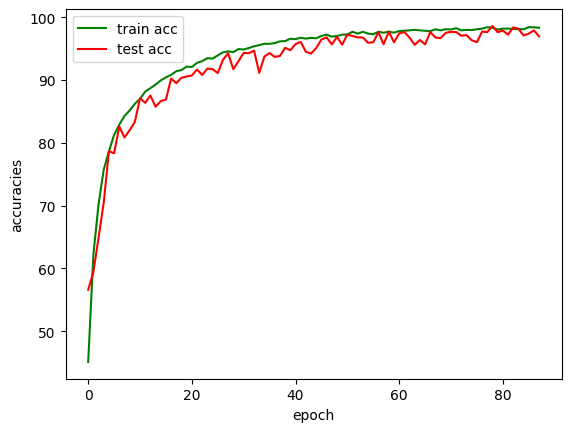

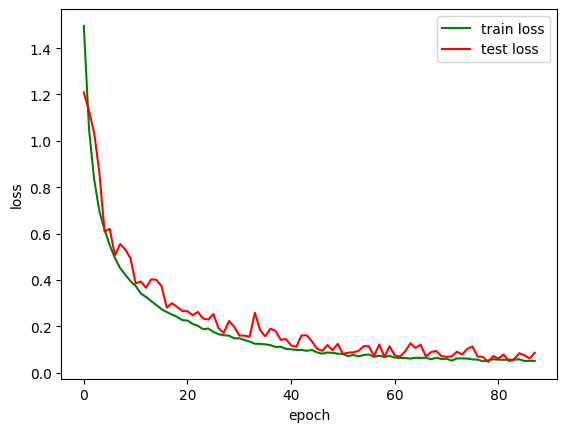

In [ ]:


plt.plot(range(len(train_accuracies)), train_accuracies, label='train acc', color='green')
plt.plot(range(len(test_accuracies)), test_accuracies, label='test acc', color='red')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.legend()
plt.show()

plt.plot(range(len(train_losses)), train_losses, label='train loss', color='green')
plt.plot(range(len(test_losses)), test_losses, label='test loss', color='red')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
load_path = ".data\\model_81_0.05745312609250033.pth"
model.load_state_dict(torch.load(load_path))

transformImageTest = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_accuracies = []
test_losses = []

testDataSet = datasets.CIFAR10(data_path, train=False, transform=transformImageTest, download=True)
testDataLoader = DataLoader(testDataSet, batch_size=train_batch_size, shuffle=False, num_workers=2)
model.eval()
model.to(device)
validation(testDataLoader, model, loss)


Files already downloaded and verified
Test Loss:  0.315 : Test Accuracy :  91.410 

